In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import corner

import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

2022-07-28 16:27:00.384065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-28 16:27:00.384097: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def timer(func):
    
    t0 = time.time()
    x = func()
    print(time.time() - t0)
    
    return x

In [3]:
# https://github.com/tensorflow/probability/issues/1410
# https://github.com/tensorflow/probability/issues/1006#issuecomment-663141106

def maf_kwargs(flow, condition):
    
    return {
        b.name: {'conditional_input': condition}
        for b in flow.bijector.bijectors if 'maf' in b.name
        }


def iaf_kwargs(flow, condition):
    
    bijectors = flow.bijector.bijectors[-1].bijector.bijectors
    prefix = bijectors[-1].name[:-1]
    
    return {
        'invert': {
            b.name: {'conditional_input': condition}
            for b in flow.bijector.bijectors[-1].bijector.bijectors if 'maf' in b.name
            }
        }

In [4]:
dims = 2
cond_dims = 1

In [5]:
distribution = tfd.Sample(
    tfd.Normal(loc=0., scale=1.),
    sample_shape=[dims],
    )

output_bijectors = [
    tfb.Scale(scale=.5),
    tfb.Shift(shift=1.),
    tfb.Tanh(),
    ]

bijectors = []
for i in range(10):
    made = tfb.AutoregressiveNetwork(
        params=2,
        event_shape=[dims],
        conditional=True,
        conditional_event_shape=[cond_dims],
        hidden_units=[1024],
        kernel_initializer='RandomNormal',
        bias_initializer='RandomNormal',
        )
    bijectors.append(tfb.MaskedAutoregressiveFlow(made, name=f'maf{i}'))

maf = tfd.TransformedDistribution(
    distribution=distribution,
    bijector=tfb.Chain(output_bijectors + bijectors),
    )
iaf = tfd.TransformedDistribution(
    distribution=distribution,
    bijector=tfb.Chain(output_bijectors + [tfb.Invert(tfb.Chain(bijectors), name='invert')]),
    )

2022-07-28 16:27:14.344974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-28 16:27:14.345035: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-28 16:27:14.345066: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (phy-190401): /proc/driver/nvidia/version does not exist
2022-07-28 16:27:14.347579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
n = 10000

1.0524587631225586
0.6062595844268799


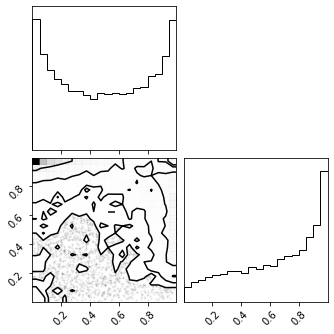

0.5113170146942139
0.715447187423706


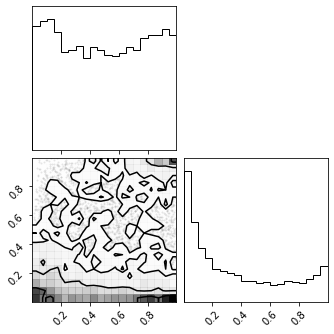

In [8]:
kw = maf_kwargs(maf, [1.])
sample = timer(lambda: maf.sample(n, bijector_kwargs=kw))
lp = timer(lambda: maf.log_prob(sample, bijector_kwargs=kw))
corner.corner(sample.numpy())
plt.show()

kw = iaf_kwargs(iaf, [1.])
sample = timer(lambda: iaf.sample(n, bijector_kwargs=kw))
lp = timer(lambda: iaf.log_prob(sample, bijector_kwargs=kw))
corner.corner(sample.numpy())
plt.show()